## 1. Imports

In [1]:
import fvdb
from fvdb.nn import VDBTensor
import torch
from UNet import SparseUNet
from torch.utils.data import Dataset
import os
from utils import setup_plots, update_plots
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


# My gpu specifically doesn't support this, if you have an RTX 3000 series or above,
# or a GPU architecture equal to or newer than Ampere you can comment/remove this.
fvdb.nn.SparseConv3d.allow_tf32 = False

## 2. ChunkDataset
This dataset definition loads minecraft chunk data stored as nvdb files into VDBTensors.

Each voxel/block contains one value which is it's offset into a global block table, stored at minecraft-serialization/block_list.txt.

In [2]:
class ChunkDataset(Dataset):
    def __init__(self, chunksPath):
        self.paths = []

        for filename in os.listdir(chunksPath):
            self.paths.append(f"{chunksPath}/{filename}")

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        grid_batch, labels, names = fvdb.load(self.paths[idx])
        labels.to(torch.long)

        return VDBTensor(grid_batch, labels)

In [3]:
dataset = ChunkDataset("data/training_data/chunks")

train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size   # 20% for validation

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

## 3. Training
In this example, we're taking the voxel grid and occupancy as an input, and attempting to predict each block offset value in the grid.

I.e. we are predicting what minecraft block each voxel is.

### 3.1 Object Intialization

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, collate_fn=fvdb.jcat, shuffle=True,)

num_classes = 0
with open("minecraft-serialization/block_list.txt", 'r') as file:
    num_classes = sum(1 for line in file)

lr = 1e-4
scheduler_step_size = 500
scheduler_gamma = 0.1

model = SparseUNet(num_classes).to('cuda')
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, scheduler_step_size, scheduler_gamma)

### 3.2 Main Training Loop

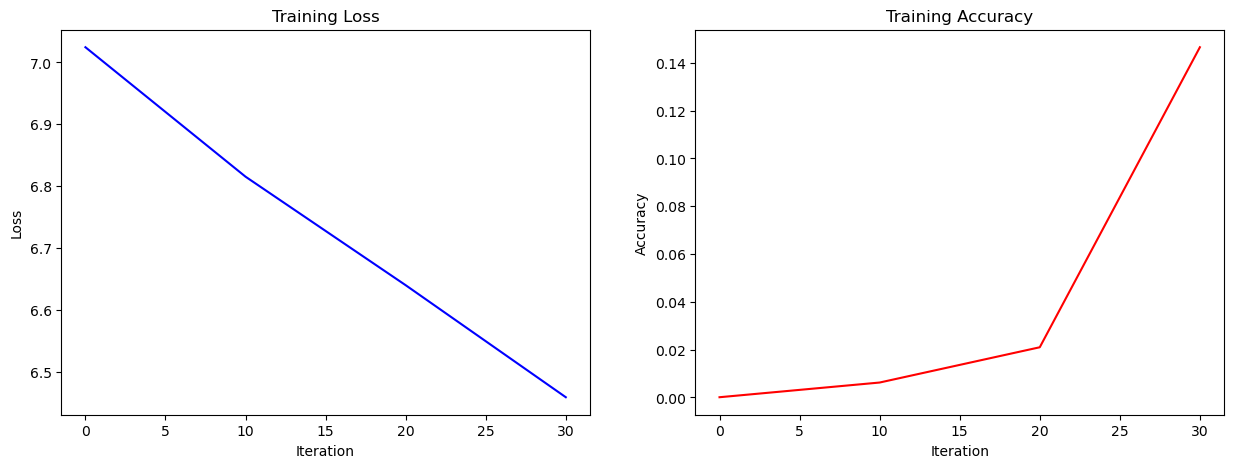

In [ ]:
fig, ax1, ax2, loss_line, acc_line = setup_plots()
plt.close() # prevents two sets of plots

losses = []
accuracies = []
iterations = []
max_epochs = 1
max_steps = 40
update_every = 10

# Training Loop
model.train()
steps_passed = 0
for epoch in range(max_epochs):
    for i, vdb_tensor in enumerate(train_loader):
        vdb_tensor = vdb_tensor.cuda()
        target = vdb_tensor.data.jdata.squeeze().to(torch.long)
        actives = vdb_tensor.grid.jagged_like(torch.ones(target.shape[0], device='cuda', dtype=torch.float32).unsqueeze(1))
        X = VDBTensor(grid=vdb_tensor.grid, data=actives)

        # forward and backward pass
        optimizer.zero_grad()
        y_hat = model(X)
        l = loss(y_hat.data.jdata, target)
        l.backward()
        optimizer.step()

        # step scheduler
        scheduler.step()

        if steps_passed % update_every == 0:
            # Calculate accuracy
            predictions = torch.argmax(y_hat.data.jdata, dim=1)
            acc = (predictions == target).float().mean()

            losses.append(l.item())
            accuracies.append(acc.item())
            iterations.append(steps_passed)
            update_plots(losses, accuracies, iterations, fig, ax1, ax2, loss_line, acc_line)

        # increment total steps passed
        steps_passed += 1
        if steps_passed >= max_steps:
            break

## Validation Accuracy

In [6]:
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, collate_fn=fvdb.jcat, shuffle=True, prefetch_factor=16, num_workers=6)

In [7]:
accuracy_sum = 0
update_every = 10
model.eval()

with torch.no_grad(), tqdm(total=len(val_loader)) as pbar:
    for i, vdb_tensor in enumerate(val_loader):
        vdb_tensor = vdb_tensor.cuda()
        target = vdb_tensor.data.jdata.squeeze().to(torch.long)
        actives = vdb_tensor.grid.jagged_like(torch.ones(target.shape[0], device='cuda', dtype=torch.float32).unsqueeze(1))

        X = VDBTensor(grid=vdb_tensor.grid, data=actives)
        y_hat = model(X)
        
        # Calculate accuracy
        predictions = torch.argmax(y_hat.data.jdata, dim=1)
        accuracy_sum += (predictions == target).float().mean()

        if (i + 1) % update_every == 0 or (i + 1) == len(val_loader):
            current_mean = accuracy_sum / (i + 1)
            pbar.set_description(f'Validating (Acc: {current_mean:.3f})')
            pbar.update(update_every if i + 1 < len(val_loader) else len(val_loader) % update_every)

mean_accuracy = accuracy_sum/len(val_loader)
print(f'Final validation accuracy: {mean_accuracy:.3f}')

  0%|          | 0/1396 [00:00<?, ?it/s]

Final validation accuracy: 0.603
